In [1]:
import numpy as np 
import pandas as pd 

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
from nsepy import get_history
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go

In [3]:
infy = get_history(symbol='INFY',
                   start=date(2020,1,1),
                   end=date(2021,1,1))
infy.head()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2020-01-01,INFY,EQ,731.15,735.0,740.0,732.55,739.35,736.85,735.35,2112415,1.553369e+14,36769,561646,0.2659
2020-01-02,INFY,EQ,736.85,738.9,740.8,730.90,735.75,734.70,735.22,5658200,4.160025e+14,102483,3413440,0.6033
2020-01-03,INFY,EQ,734.70,733.9,748.0,733.90,745.00,746.00,744.67,7882938,5.870173e+14,105632,3682521,0.4672
2020-01-06,INFY,EQ,746.00,746.1,753.8,736.50,738.50,738.85,743.51,6519403,4.847237e+14,129992,2871332,0.4404
2020-01-07,INFY,EQ,738.85,738.0,742.6,725.10,729.30,727.90,734.63,7899363,5.803120e+14,189680,3976564,0.5034


In [4]:
infy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 253 entries, 2020-01-01 to 2021-01-01
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol              253 non-null    object 
 1   Series              253 non-null    object 
 2   Prev Close          253 non-null    float64
 3   Open                253 non-null    float64
 4   High                253 non-null    float64
 5   Low                 253 non-null    float64
 6   Last                253 non-null    float64
 7   Close               253 non-null    float64
 8   VWAP                253 non-null    float64
 9   Volume              253 non-null    int64  
 10  Turnover            253 non-null    float64
 11  Trades              253 non-null    int64  
 12  Deliverable Volume  253 non-null    int64  
 13  %Deliverble         253 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 29.6+ KB


### creating a model to forecast the closing price of the INFY stock 

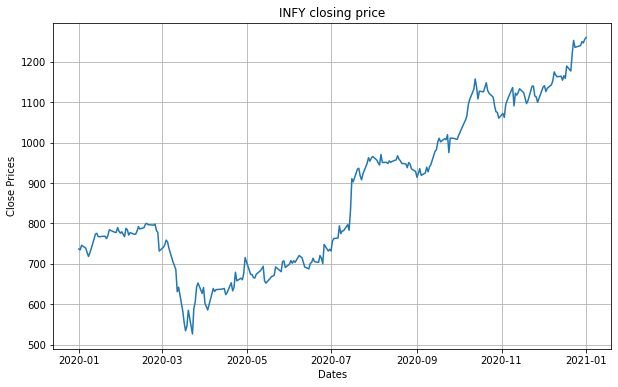

In [5]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(infy['Close'])
plt.title('INFY closing price')
plt.show()


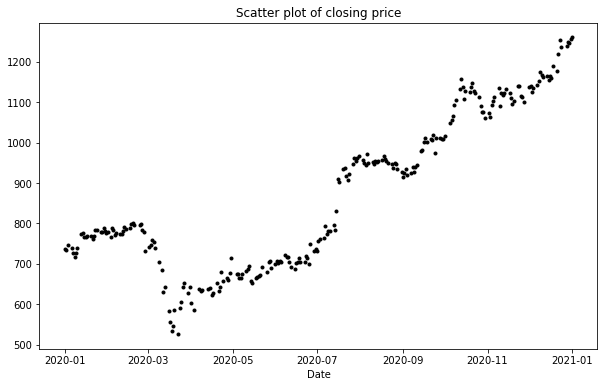

In [6]:
plt.figure(figsize=(10,6))
df_close = infy['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

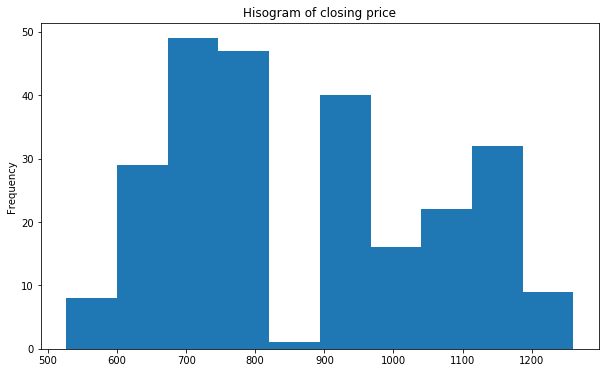

In [7]:
plt.figure(figsize=(10,6))
df_close = infy['Close']
df_close.plot(style='k.',kind='hist')
plt.title('Hisogram of closing price')
plt.show()

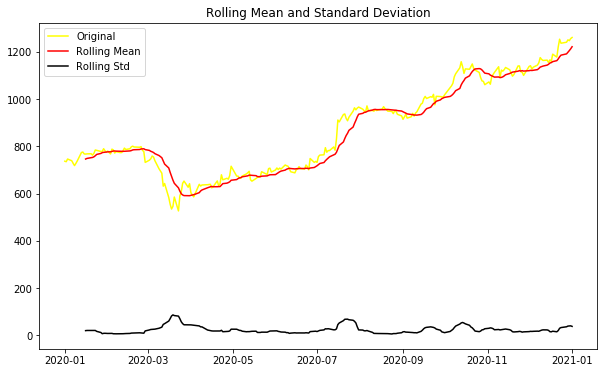

Results of dickey fuller test
Test Statistics                  0.586553
p-value                          0.987279
No. of lags used                 1.000000
Number of observations used    251.000000
critical value (1%)             -3.456674
critical value (5%)             -2.873125
critical value (10%)            -2.572944
dtype: float64


In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(infy['Close'])

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

<Figure size 720x432 with 0 Axes>

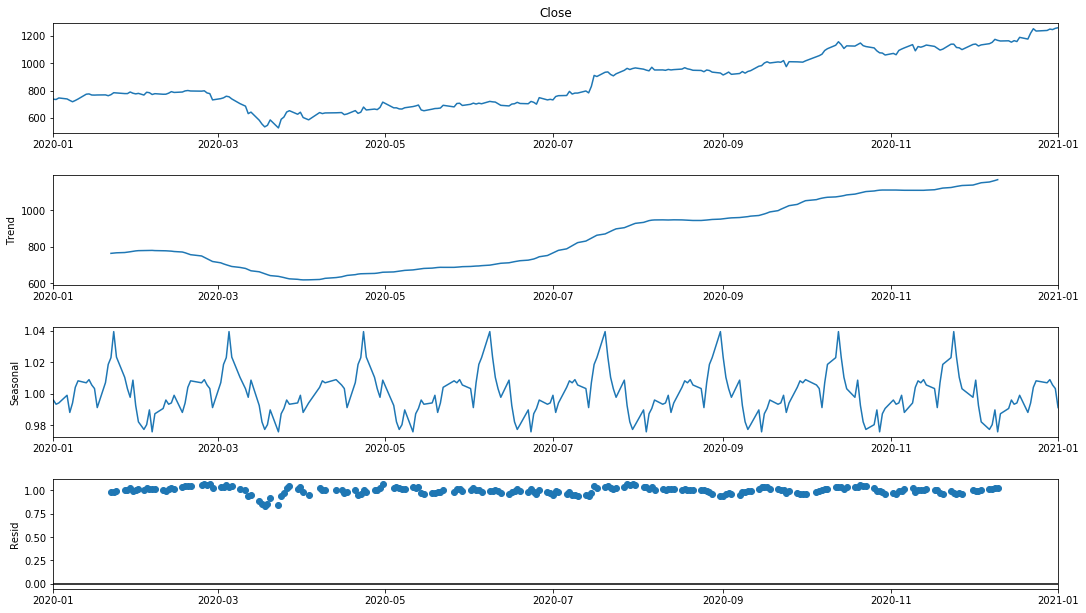

In [9]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


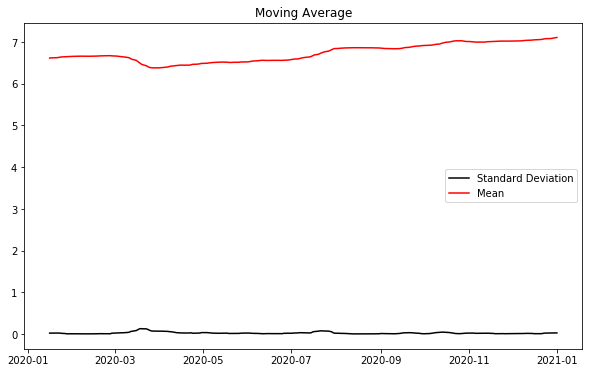

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(infy['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

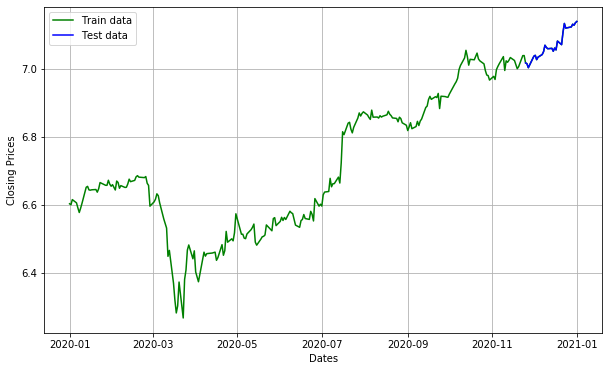

In [11]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [12]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
test='adf',       # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1,              # frequency of series
d=None,           # let model determine 'd'
seasonal=False,   # No Seasonality
start_P=0, 
D=0, 
trace=True,
error_action='ignore',  
suppress_warnings=True, 
stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-989.352, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-991.167, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-990.507, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-990.116, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-990.845, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-989.710, Time=0.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-990.059, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-991.558, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-991.501, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-990.150, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-990.936, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-990.944, Time=0.16 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.144 seconds
                               SARIMAX Results                                
Dep. Vari

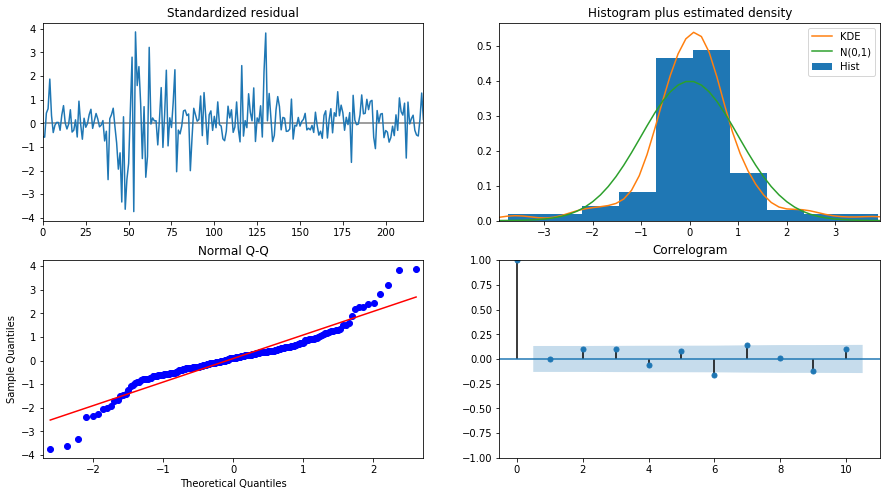

In [13]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [14]:
model = ARIMA(train_data, order=(3, 1, 2))
fitted = model.fit(disp=-1)
print(fitted.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 507.123
Method:                       css-mle   S.D. of innovations              0.025
Date:                Thu, 06 May 2021   AIC                          -1000.247
Time:                        19:04:23   BIC                           -976.397
Sample:                             1   HQIC                          -990.619
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.002      1.200      0.230      -0.001       0.005
ar.L1.D.Close    -1.5130      0.082    -18.518      0.000      -1.673      -1.353
ar.L2.D.Close    -0.9042      0.131     

In [15]:
# Forecast

fc, se, conf = fitted.forecast(26, alpha=0.05)  # 95% confidence

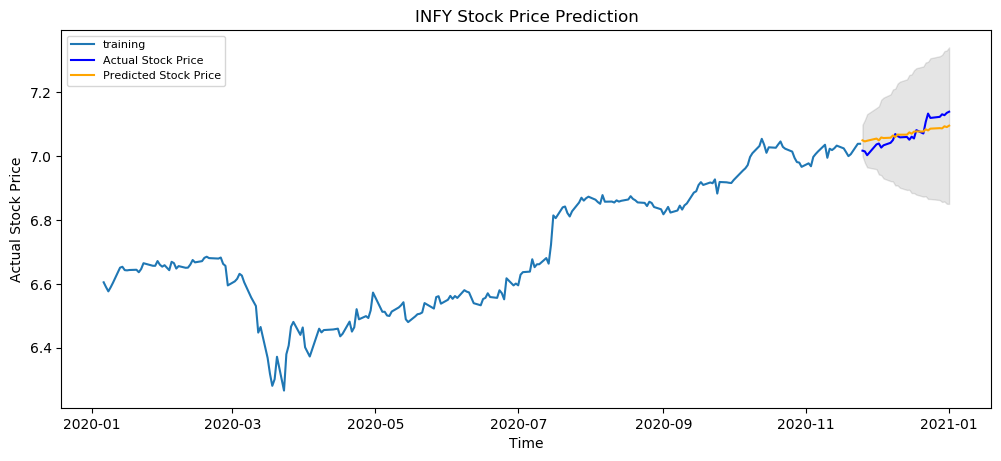

In [16]:

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('INFY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [17]:
infy.head() 

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2020-01-01,INFY,EQ,731.15,735.0,740.0,732.55,739.35,736.85,735.35,2112415,1.553369e+14,36769,561646,0.2659
2020-01-02,INFY,EQ,736.85,738.9,740.8,730.90,735.75,734.70,735.22,5658200,4.160025e+14,102483,3413440,0.6033
2020-01-03,INFY,EQ,734.70,733.9,748.0,733.90,745.00,746.00,744.67,7882938,5.870173e+14,105632,3682521,0.4672
2020-01-06,INFY,EQ,746.00,746.1,753.8,736.50,738.50,738.85,743.51,6519403,4.847237e+14,129992,2871332,0.4404
2020-01-07,INFY,EQ,738.85,738.0,742.6,725.10,729.30,727.90,734.63,7899363,5.803120e+14,189680,3976564,0.5034


In [18]:
fc_series

Date
2020-11-25    7.049509
2020-11-26    7.046172
2020-11-27    7.048244
2020-12-01    7.055105
2020-12-02    7.049433
2020-12-03    7.058546
2020-12-04    7.056757
2020-12-07    7.057739
2020-12-08    7.064806
2020-12-09    7.059852
2020-12-10    7.067662
2020-12-11    7.067202
2020-12-14    7.067372
2020-12-15    7.074428
2020-12-16    7.070263
2020-12-17    7.076866
2020-12-18    7.077517
2020-12-21    7.077120
2020-12-22    7.083996
2020-12-23    7.080647
2020-12-24    7.086162
2020-12-28    7.087717
2020-12-29    7.086959
2020-12-30    7.093533
2020-12-31    7.090993
2021-01-01    7.095547
dtype: float64

In [41]:
infy.reset_index(inplace=True)
# infy_ill=infy_ill[200:]

In [44]:
#create the figure container with data object. The trace is a candlestick chart
fig = go.Figure(data = [ go.Candlestick(
    x = infy['Date'][100:],
    open  = infy['Open'][100:],
    high = infy['High'][100:],
    low = infy['Low'][100:],
    close = infy['Close'][100:]
)])

# create the layout object with rangeslider value as false
fig.update_layout (title_text = "Infy Candles july 2020 till date",
                  xaxis = dict(
                      rangeslider = dict(
                          visible = False
                      )
                  ))

#plot the figure container
fig.show()